# Intent Detection 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
from transformers import (AutoModelForSequenceClassification, AutoTokenizer,
                          Trainer, TrainingArguments,TextClassificationPipeline)

RANDOM_SEED = 34

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [2]:
t1 = torch.randn(1,2)
t2 = torch.randn(1,2).to(device)
print(t1)  # tensor([[-0.2678,  1.9252]])
print(t2)  # tensor([[ 0.5117, -3.6247]], device='cuda:0')

tensor([[-1.6277,  0.9305]])
tensor([[-0.7402, -0.3292]], device='cuda:0')


In [3]:
clinc = load_dataset("clinc_oos","plus")
clinc

Reusing dataset clinc_oos (/home/ubuntu/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [4]:
clinc["train"][10]

{'text': "how would i say, 'i don't know the answer' in spanish", 'intent': 61}

In [5]:
# Here intents are provided as ID's can be converted string
intents = clinc["train"].features["intent"]

In [6]:
intents.int2str(clinc["train"][10]["intent"])

'translate'

In [7]:
train_dataset = clinc['train']
val_dataset = clinc['validation']
test_dataset = clinc['test']

In [8]:
train_dataset

Dataset({
    features: ['text', 'intent'],
    num_rows: 15250
})

In [9]:
train_dataset.column_names

['text', 'intent']

In [10]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'intent': ClassLabel(num_classes=151, names=['restaurant_reviews', 'nutrition_info', 'account_blocked', 'oil_change_how', 'time', 'weather', 'redeem_rewards', 'interest_rate', 'gas_type', 'accept_reservations', 'smart_home', 'user_name', 'report_lost_card', 'repeat', 'whisper_mode', 'what_are_your_hobbies', 'order', 'jump_start', 'schedule_meeting', 'meeting_schedule', 'freeze_account', 'what_song', 'meaning_of_life', 'restaurant_reservation', 'traffic', 'make_call', 'text', 'bill_balance', 'improve_credit_score', 'change_language', 'no', 'measurement_conversion', 'timer', 'flip_coin', 'do_you_have_pets', 'balance', 'tell_joke', 'last_maintenance', 'exchange_rate', 'uber', 'car_rental', 'credit_limit', 'oos', 'shopping_list', 'expiration_date', 'routing', 'meal_suggestion', 'tire_change', 'todo_list', 'card_declined', 'rewards_balance', 'change_accent', 'vaccines', 'reminder_update', 'food_last', 'change_ai_name', 'bill_due', 'who_do_you_work_f

## Convert Dataset to Dataframe

In [11]:
clinc.set_format(type='pandas')
df = clinc["train"][:]
df.head()

,text,intent
0,what expression would i use to say i love you ...,61
1,can you tell me how to say 'i do not speak muc...,61
2,"what is the equivalent of, 'life is good' in f...",61
3,"tell me how to say, 'it is a beautiful morning...",61
4,"if i were mongolian, how would i say that i am...",61


In [12]:
# convert int2str for all intents
def label_int2str(row,split):
    return clinc[split].features["intent"].int2str(row)

df["intent_name"] = df.intent.apply(label_int2str,split='train')
df.sample(10)

,text,intent,intent_name
14226,my car battery has died what should i do now,17,jump_start
147,whats the quickest way to money from one accou...,133,transfer
13837,say something funny,36,tell_joke
2702,i need you to block my chase account immediately,20,freeze_account
6901,please set up a reminder i need to remember to...,53,reminder_update
8205,describe your types of pets,34,do_you_have_pets
5963,what's the date 400 days from now,95,date
6390,inform my bank i will be travelling to central...,146,travel_notification
5849,what is 1 million twelve hundred divided by 40...,138,calculator
7807,what is the calorie content of a scoop of choc...,135,calories


In [13]:
pd.options.display.max_rows = 160
pd.DataFrame(df.intent_name.value_counts(ascending=False))

,intent_name
oos,250
international_visa,100
todo_list_update,100
reminder,100
transactions,100
freeze_account,100
report_lost_card,100
vaccines,100
change_language,100
travel_suggestion,100


Looks like we have 100 instances for each intent.

## Sentence length of the Queries

In [14]:
df['text_length'] = df.text.str.split().apply(len)

In [15]:
df.text_length.max()

28

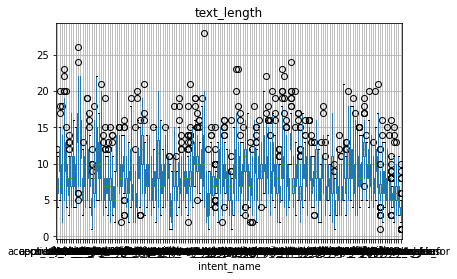

In [16]:
df.boxplot('text_length',by='intent_name')
plt.suptitle('')
plt.show()

The max length of the Sentences is around 28.

## Fine Tuning the Model

In [17]:
num_labels = clinc['train'].features['intent'].num_classes

MODEL_NAME = "bert-base-uncased" # Any model from Hub or Pretrained Model Directory
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
def tokenize(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

clinc.reset_format()

In [19]:
clinc.rename_column_('intent','labels')

/home/ubuntu/anaconda3/envs/transformers/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: rename_column_ is deprecated and will be removed in the next major version of datasets. Use DatasetDict.rename_column instead.
  """Entry point for launching an IPython kernel.


In [20]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5500
    })
})

In [21]:
# Tokenize using the DatasetDict features

clinc_encoded = clinc.map(tokenize,batched=True,batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
clinc_encoded['train'].features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'labels': ClassLabel(num_classes=151, names=['restaurant_reviews', 'nutrition_info', 'account_blocked', 'oil_change_how', 'time', 'weather', 'redeem_rewards', 'interest_rate', 'gas_type', 'accept_reservations', 'smart_home', 'user_name', 'report_lost_card', 'repeat', 'whisper_mode', 'what_are_your_hobbies', 'order', 'jump_start', 'schedule_meeting', 'meeting_schedule', 'freeze_account', 'what_song', 'meaning_of_life', 'restaurant_reservation', 'traffic', 'make_call', 'text', 'bill_balance', 'improve_credit_score', 'change_language', 'no', 'measurement_conversion', 'timer', 'flip_coin', 'do_you_have_pets', 'balance', 'tell_joke', 'last_maintenance', 'exchange_rate', 'uber', 'car_rental', 'credit_limit', 'oos', 'shopping_list', 'expiration_date', 'routing', 'meal_suggestion', 'tire_change', 'todo_list', 'card_declined',

In [25]:
# Convert format to Torch Tensors for training the model

clinc_encoded.set_format('torch',columns=['input_ids','token_type_ids','attention_mask','labels'])

In [27]:
clinc_encoded['train'][10]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([ 101, 2129, 2052, 1045, 2360, 1010, 1005, 1045, 2123, 1005, 1056, 2113,
         1996, 3437, 1005, 1999, 3009,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0]),
 'labels': tensor(61),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [28]:
# Define Metrics

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred,average="weighted")
    precision = precision_score(y_true=labels, y_pred=pred,average="weighted")
    f1 = f1_score(y_true=labels, y_pred=pred,average="weighted")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [29]:
clinc_encoded

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text', 'token_type_ids'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text', 'token_type_ids'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text', 'token_type_ids'],
        num_rows: 5500
    })
})

In [30]:
# Define Trainer
logging_steps = len(clinc_encoded['train']) // 32

args = TrainingArguments(
    output_dir=f"results-{MODEL_NAME}",
    evaluation_strategy="epoch",
    warmup_steps = 250,
    # label_smoothing_factor = 0.8,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    save_strategy='epoch',
    # save_steps=250,
    seed=RANDOM_SEED,
    learning_rate=2e-5,
    fp16=True,
    weight_decay=0.01,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    disable_tqdm=False,
    logging_steps = logging_steps
)

In [31]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=clinc_encoded['train'],
    eval_dataset=clinc_encoded['validation'],
    compute_metrics=compute_metrics
)

# Train pre-trained model
trainer.train()

Trainer is attempting to log a value of "{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3', 4: 'LABEL_4', 5: 'LABEL_5', 6: 'LABEL_6', 7: 'LABEL_7', 8: 'LABEL_8', 9: 'LABEL_9', 10: 'LABEL_10', 11: 'LABEL_11', 12: 'LABEL_12', 13: 'LABEL_13', 14: 'LABEL_14', 15: 'LABEL_15', 16: 'LABEL_16', 17: 'LABEL_17', 18: 'LABEL_18', 19: 'LABEL_19', 20: 'LABEL_20', 21: 'LABEL_21', 22: 'LABEL_22', 23: 'LABEL_23', 24: 'LABEL_24', 25: 'LABEL_25', 26: 'LABEL_26', 27: 'LABEL_27', 28: 'LABEL_28', 29: 'LABEL_29', 30: 'LABEL_30', 31: 'LABEL_31', 32: 'LABEL_32', 33: 'LABEL_33', 34: 'LABEL_34', 35: 'LABEL_35', 36: 'LABEL_36', 37: 'LABEL_37', 38: 'LABEL_38', 39: 'LABEL_39', 40: 'LABEL_40', 41: 'LABEL_41', 42: 'LABEL_42', 43: 'LABEL_43', 44: 'LABEL_44', 45: 'LABEL_45', 46: 'LABEL_46', 47: 'LABEL_47', 48: 'LABEL_48', 49: 'LABEL_49', 50: 'LABEL_50', 51: 'LABEL_51', 52: 'LABEL_52', 53: 'LABEL_53', 54: 'LABEL_54', 55: 'LABEL_55', 56: 'LABEL_56', 57: 'LABEL_57', 58: 'LABEL_58', 59: 'LABEL_59', 60: 'LABEL_60', 61

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Runtime,Samples Per Second
1,4.554400,3.481804,0.618387,0.678763,0.618387,0.579020,5.348600,579.596000
2,2.954700,2.559270,0.826774,0.851824,0.826774,0.814906,5.333800,581.202000


/home/ubuntu/anaconda3/envs/transformers/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/transformers/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=954, training_loss=3.752625076525866, metrics={'train_runtime': 257.9652, 'train_samples_per_second': 3.698, 'total_flos': 661864490001000.0, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 15466496, 'train_mem_gpu_alloc_delta': 1807629824, 'train_mem_cpu_peaked_delta': 362598400, 'train_mem_gpu_peaked_delta': 337538560})

In [32]:
trainer.evaluate()

/home/ubuntu/anaconda3/envs/transformers/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 2.559270143508911,
 'eval_accuracy': 0.8267741935483871,
 'eval_precision': 0.8518240398384863,
 'eval_recall': 0.8267741935483871,
 'eval_f1': 0.8149062091514169,
 'eval_runtime': 5.6337,
 'eval_samples_per_second': 550.259,
 'epoch': 2.0,
 'eval_mem_cpu_alloc_delta': 192512,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_peaked_delta': 33443328}

In [33]:
test_preds = trainer.predict(clinc_encoded['test'])

/home/ubuntu/anaconda3/envs/transformers/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
test_preds.metrics

{'test_loss': 2.798470973968506,
 'test_accuracy': 0.742,
 'test_precision': 0.8034928500807291,
 'test_recall': 0.742,
 'test_f1': 0.7196311976822789,
 'test_runtime': 9.7643,
 'test_samples_per_second': 563.275,
 'test_mem_cpu_alloc_delta': 327680,
 'test_mem_gpu_alloc_delta': 0,
 'test_mem_cpu_peaked_delta': 0,
 'test_mem_gpu_peaked_delta': 36339200}

In [35]:
labels = clinc_encoded['test'].features['labels'].names

In [36]:
def label_int2str(row,split):
    return clinc[split].features["labels"].int2str(row)

label_int2str(0,'test')

'restaurant_reviews'

In [37]:
from sklearn.metrics import classification_report

y_preds = np.argmax(test_preds.predictions,axis=1)
y_test = np.array(clinc_encoded['test']['labels'])

print(classification_report(y_test,y_preds,target_names=labels))

                           precision    recall  f1-score   support

       restaurant_reviews       0.62      0.70      0.66        30
           nutrition_info       0.50      1.00      0.67        30
          account_blocked       0.66      0.77      0.71        30
           oil_change_how       0.70      1.00      0.82        30
                     time       0.83      0.97      0.89        30
                  weather       0.68      1.00      0.81        30
           redeem_rewards       0.61      0.83      0.70        30
            interest_rate       0.72      0.93      0.81        30
                 gas_type       0.93      0.43      0.59        30
      accept_reservations       0.82      0.93      0.87        30
               smart_home       0.59      0.43      0.50        30
                user_name       0.62      0.97      0.75        30
         report_lost_card       0.95      0.67      0.78        30
                   repeat       0.93      0.90      0.92     

/home/ubuntu/anaconda3/envs/transformers/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/transformers/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/transformers/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

## Save Model

In [38]:
MODEL_DIR = os.path.join('models',f'{MODEL_NAME}')

trainer.save_model(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)

('models/bert-base-uncased/tokenizer_config.json',
 'models/bert-base-uncased/special_tokens_map.json',
 'models/bert-base-uncased/vocab.txt',
 'models/bert-base-uncased/added_tokens.json')

## Infer with Pipeline

In [57]:
tokenizer = AutoTokenizer.from_pretrained('./models/bert-base-uncased')
bert_model = AutoModelForSequenceClassification.from_pretrained('./models/bert-base-uncased', num_labels=num_labels).to(device)

test_trainer = Trainer(bert_model)
model = test_trainer.model
model.to('cpu')

pipe = TextClassificationPipeline(model = model,tokenizer= tokenizer)

In [58]:
pipe('I need to book a cab to the airport')

[{'label': 'uber', 'score': 0.03775889053940773}]

In [ ]:
label_int2str(40,'train')

'car_rental'

## Check Latency

In [59]:
from time import perf_counter

def time_pipeline(pipeline, query="What is the pin number for my account?"):
    latencies = []
    # Warmup
    for _ in range(10):
        _ = pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}


In [60]:
time_pipeline(pipe)

Average latency (ms) - 107.32 +\- 6.61


{'time_avg_ms': 107.31986364975455, 'time_std_ms': 6.611618580876083}

## Knowledge Distillation

Distill Bert-base to Distilbert-base

In [68]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs,return_outputs=False):
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        if return_outputs:
            return  loss,outputs_stu
        return loss

In [69]:
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch, tokenizer):
    return tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"],
                      fn_kwargs={"tokenizer": student_tokenizer})
# clinc_enc.rename_column_("intent", "labels")

Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-8d3b2e3c7fc02626.arrow
Loading cached processed dataset at /home/ubuntu/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1/cache-d7f80672a29cfd4c.arrow


  0%|          | 0/6 [00:00<?, ?ba/s]

In [70]:
import torch
from transformers import AutoConfig

num_labels = intents.num_classes
id2label = bert_model.config.id2label
label2id = bert_model.config.label2id
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [75]:
from datasets import load_metric
accuracy_score = load_metric('accuracy')


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

batch_size = 48

student_training_args = DistillationTrainingArguments(
    output_dir="checkpoints", evaluation_strategy = "epoch", num_train_epochs=5,
    learning_rate=2e-5, per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01)

teacher_checkpoint = "./models/bert-base-uncased"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_checkpoint, num_labels=num_labels)
                 .to(device))

distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [76]:
import mlflow
mlflow.end_run()

In [77]:
distil_trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,No log,3.295276,0.701613,16.477200,188.139000
2,3.798400,1.880418,0.846129,16.244200,190.837000
3,3.798400,1.154230,0.891290,16.620700,186.514000
4,1.699700,0.850301,0.912581,16.526500,187.577000
5,0.901500,0.766742,0.918710,16.530400,187.533000


TrainOutput(global_step=1590, training_loss=2.05552752992642, metrics={'train_runtime': 1555.355, 'train_samples_per_second': 1.022, 'total_flos': 640588370600100.0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 4096, 'init_mem_gpu_alloc_delta': 269083648, 'init_mem_cpu_peaked_delta': 93528064, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1376256, 'train_mem_gpu_alloc_delta': 812962816, 'train_mem_cpu_peaked_delta': 93499392, 'train_mem_gpu_peaked_delta': 589137408})

In [79]:
test_preds = distil_trainer.predict(clinc_encoded['test'])

y_preds = np.argmax(test_preds.predictions,axis=1)
y_test = np.array(clinc_encoded['test']['labels'])

print(classification_report(y_test,y_preds,target_names=labels))

                           precision    recall  f1-score   support

       restaurant_reviews       0.81      0.73      0.77        30
           nutrition_info       0.91      1.00      0.95        30
          account_blocked       0.92      0.80      0.86        30
           oil_change_how       0.75      1.00      0.86        30
                     time       0.82      0.93      0.87        30
                  weather       0.68      1.00      0.81        30
           redeem_rewards       1.00      0.80      0.89        30
            interest_rate       0.85      0.93      0.89        30
                 gas_type       1.00      0.83      0.91        30
      accept_reservations       0.87      0.87      0.87        30
               smart_home       0.56      0.97      0.71        30
                user_name       0.59      0.97      0.73        30
         report_lost_card       0.90      0.90      0.90        30
                   repeat       0.93      0.90      0.92     

In [78]:
distil_trainer.save_model("./models/distilled-student")

In [82]:
distilled_model = distil_trainer.model
distilled_model.to('cpu')
pipe_quantized = TextClassificationPipeline(model = distilled_model,tokenizer= student_tokenizer)
time_pipeline(pipe_quantized)

Average latency (ms) - 83.65 +\- 5.78


{'time_avg_ms': 83.64590561999648, 'time_std_ms': 5.78353258933826}

### Quantization

In [83]:
from torch.quantization import quantize_dynamic

model_quantized = quantize_dynamic(distilled_model,{torch.nn.Linear},dtype=torch.qint8)


In [ ]:
pipe_quantized = TextClassificationPipeline(model = model_quantized,tokenizer= student_tokenizer)
time_pipeline(pipe_quantized)